In [12]:
import os
import sys
import copy
import json
import importlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
import time
import torch
import torchaudio
import tensorflow as tf
import tqdm

import phaselocknet_model
import util

importlib.reload(phaselocknet_model)
importlib.reload(util)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device


device(type='cuda', index=0)

In [95]:
# dir_model = "../phaselocknet/models/sound_localization/simplified_IHC3000_delayed_integration/arch01"
# input_shape = [2, 60000, 2]
# config_random_slice = {"size": [50, 10000], "buffer": [0, 500]}

# dir_model = "../phaselocknet/models/sound_localization/IHC3000_delayed_integration/arch01"
# input_shape = [2, 3, 50, 12000, 2]
# config_random_slice = {"size": [50, 10000], "buffer": [0, 500]}

# dir_model = "../phaselocknet/models/spkr_word_recognition/simplified_IHC3000/arch0_0000"
# input_shape = [2, 40000]
# config_random_slice = {"size": [50, 20000], "buffer": [0, 0]}

# dir_model = "../phaselocknet/models/spkr_word_recognition/IHC3000/arch0_0000"
# input_shape = [2, 3, 50, 20000]
# config_random_slice = {}

dir_model = "../phaselocknet/models/sound_localization/simplified_IHC3000_delayed_integration/arch01"
input_shape = [2, 50000, 2]
config_random_slice = {"size": [50, 10000], "buffer": [0, 0]}

with open(os.path.join(dir_model, "config.json")) as f:
    config_model = json.load(f)
with open(os.path.join(dir_model, "arch.json")) as f:
    architecture = json.load(f)

config_model["kwargs_cochlea"]["kwargs_spike_generator_binomial"] = {}

model = phaselocknet_model.Model(
    config_model=copy.deepcopy(config_model),
    architecture=copy.deepcopy(architecture),
    input_shape=input_shape,
    config_random_slice=copy.deepcopy(config_random_slice),
).to(device)

for k, v in model(torch.zeros(model.input_shape, device=device)).items():
    print(k, v.shape, v.dtype)

util.load_tf_model_checkpoint(
    model=model.perceptual_model,
    filename=os.path.join(dir_model, "ckpt_BEST"),
)


label_loc_int torch.Size([2, 504]) torch.float32
[load_tf_model_checkpoint] ../phaselocknet/models/sound_localization/simplified_IHC3000_delayed_integration/arch01/ckpt_BEST


'../phaselocknet/models/sound_localization/simplified_IHC3000_delayed_integration/arch01/ckpt_BEST'

In [96]:
sys.path.append("../phaselocknet")
import util_cochlea
import util_network
import util_signal


def model_io_function(x):
    y = x
    if config_model.get("kwargs_cochlea", {}):
        if "label_loc_int" in config_model["n_classes_dict"]:
            msg = "expected [batch, freq, time, spont, channel=2] or [batch, time, channel=2]"
            assert (len(y.shape) in [3, 5]) and (y.shape[-1] == 2), msg
            y0, _ = util_cochlea.cochlea(y[..., 0], **copy.deepcopy(config_model["kwargs_cochlea"]))
            y1, _ = util_cochlea.cochlea(y[..., 1], **copy.deepcopy(config_model["kwargs_cochlea"]))
            y = tf.concat([y0, y1], axis=-1)
            if y.shape[2] > 10000:
                y = util_cochlea.random_slice(
                    y,
                    slice_length=10000,
                    axis=2, # Time axis
                    buffer=500)
        else:
            y, _ = util_cochlea.cochlea(y, **copy.deepcopy(config_model["kwargs_cochlea"]))
    # y, _ = util_network.build_network(y, architecture, n_classes_dict=config_model["n_classes_dict"])
    return y


with open(os.path.join(dir_model, "config.json")) as f:
    config_model = json.load(f)
with open(os.path.join(dir_model, "arch.json")) as f:
    architecture = json.load(f)

config_model["kwargs_cochlea"]["kwargs_spike_generator_binomial"] = {}

inputs = tf.keras.Input(shape=input_shape[1:], batch_size=None, dtype=tf.float32)
tf_model = tf.keras.Model(inputs=inputs, outputs=model_io_function(inputs))
# tf_model.load_weights(os.path.join(dir_model, "ckpt_BEST"))


[cochlea] converting audio to subbands using fir_gammatone_filterbank
[cochlea] half-wave rectified subbands
[tf_fir_resample] interpreted `tensor_input.shape` as [batch, freq=50, time=50000]
[tf_fir_resample] `kwargs_fir_lowpass_filter`: {'cutoff': 3000, 'fir_dur': 0.05, 'ihc_filter': True, 'order': 7}
[fir_lowpass_filter] sr_filt = 50000.0 Hz
[fir_lowpass_filter] numtaps = 2501 samples
[fir_lowpass_filter] fir_dur = 0.05 seconds
[fir_lowpass_filter] cutoff = 3000 Hz
[fir_lowpass_filter] order = 7 (bez2018model IHC filter)
[cochlea] resampled subbands from 50000 Hz to 10000 Hz with filter: {'cutoff': 3000, 'fir_dur': 0.05, 'ihc_filter': True, 'order': 7}
[cochlea] half-wave rectified resampled subbands
[cochlea] incorporated sigmoid_rate_level_function: {'dynamic_range': [20.0, 40.0, 80.0], 'dynamic_range_interval': 0.95, 'envelope_mode': True, 'rate_max': [250.0, 250.0, 250.0], 'rate_spont': [0.0, 0.0, 0.0], 'threshold': [0.0, 12.0, 28.0]}
[cochlea] converting audio to subbands using

In [97]:
x = np.random.randn(*input_shape).astype(np.float32)

nervegram_torch = model.peripheral_model(torch.tensor(x).to(device)).cpu().numpy()
print(nervegram_torch.shape, nervegram_torch.dtype)

nervegram_tf = tf_model(x).numpy()
nervegram_tf = np.transpose(nervegram_tf, [0, 3, 1, 2])
print(nervegram_tf.shape, nervegram_tf.dtype)

np.isclose(nervegram_torch, nervegram_tf).mean()


(2, 6, 50, 10000) float32
(2, 6, 50, 10000) float32


0.9946715

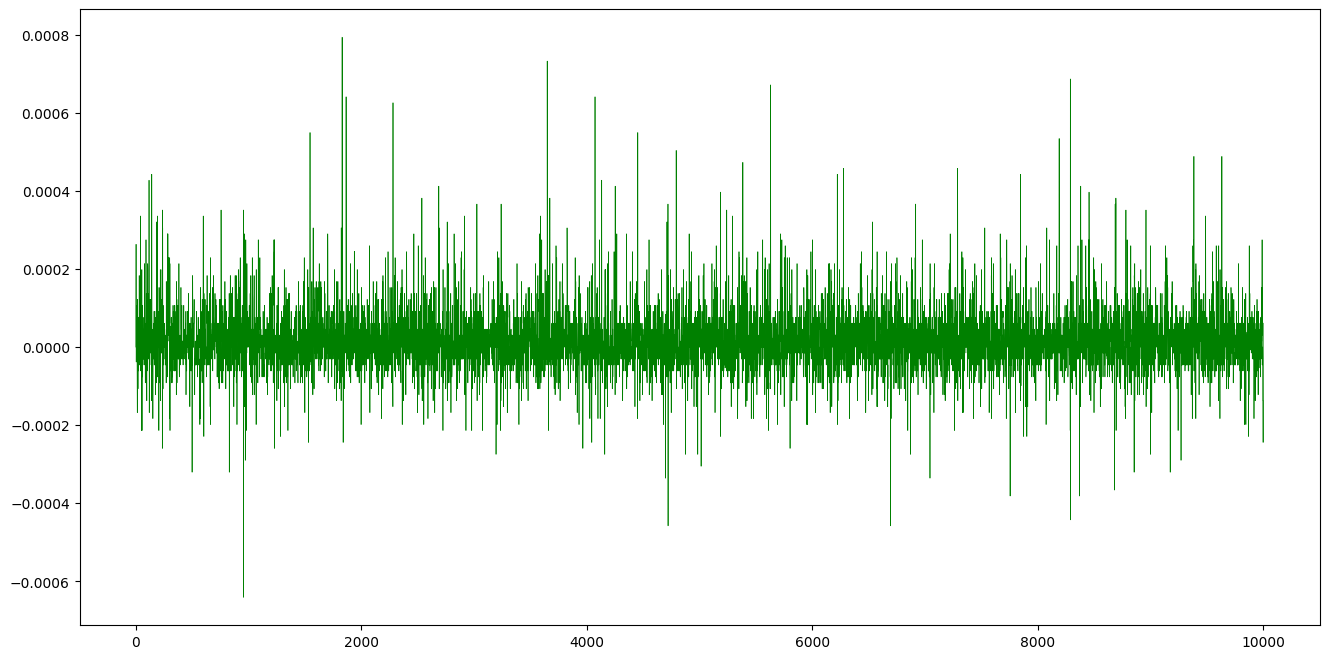

PearsonRResult(statistic=0.9999999999973759, pvalue=0.0)


In [102]:
fig, ax = plt.subplots(figsize=(16, 8))

IDX = (0, 0, -4)
# ax.plot(nervegram_tf[IDX], ls="-", color="k")
# ax.plot(nervegram_torch[IDX], ls="--", color="r", lw=0.5)
ax.plot(nervegram_torch[IDX].reshape([-1]) - nervegram_tf[IDX].reshape([-1]), ls="-", color="g", lw=0.5)
plt.show()

print(scipy.stats.pearsonr(nervegram_torch[IDX].reshape([-1]), nervegram_tf[IDX].reshape([-1])))


In [103]:
torch_coch = model.peripheral_model.body.cochlear_filterbank.fb(torch.tensor(x[..., 0]).to(device)).cpu().numpy()

tf_coch = util_signal.fir_gammatone_filterbank(
    x[..., 0],
    sr=config_model["kwargs_cochlea"]["sr_input"],
    fir_dur=config_model["kwargs_cochlea"]["config_filterbank"]["fir_dur"],
    min_cf=config_model["kwargs_cochlea"]["config_filterbank"]["min_cf"],
    max_cf=config_model["kwargs_cochlea"]["config_filterbank"]["max_cf"],
    num_cf=config_model["kwargs_cochlea"]["config_filterbank"]["num_cf"],
    return_io_function=False
).numpy()

torch_coch.shape, tf_coch.shape, np.isclose(torch_coch, tf_coch).mean()


((2, 50, 50000), (2, 50, 50000), 0.9966424)

In [5]:
for _ in tqdm.tqdm(range(20)):
    x = torch.randn(model.input_shape, device=device)
    model(x)
x.shape


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 39.89it/s]


torch.Size([2, 60000, 2])

In [33]:
# regex_filenames = "../phaselocknet/stimuli/sound_localization/evaluation/speech_in_noise_in_reverb_v04/stim.hdf5"
regex_filenames = "../phaselocknet/stimuli/sound_localization/evaluation/mp_spectral_cues/stim.hdf5"
# regex_filenames = "../phaselocknet/stimuli/spkr_word_recognition/evaluation/pitch_altered_v00/stim.hdf5"
batch_size = 32
sr = 50000 if "sound_localization" in regex_filenames else 20000
num_steps_per_display = 10
dataset = util.HDF5Dataset(regex_filenames)

dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=batch_size,
    num_workers=1,
    shuffle=False,
)


In [34]:
fn_eval_output = "tmp.csv"
overwrite = True
write_prob = True

if os.path.exists(fn_eval_output):
    if overwrite:
        print(f"[evaluate] Overwriting pre-existing {fn_eval_output=}")
        os.remove(fn_eval_output)
    else:
        print(f"[complete] {fn_eval_output=} already exists!")
        raise ValueError(f"[complete] {fn_eval_output=} already exists!")
if os.path.exists(fn_eval_output + "~"):
    print(f"[evaluate] Deleting pre-existing tempfile: {fn_eval_output}~")
    os.remove(fn_eval_output + "~")

if write_prob:
    df_prob = []
    fn_eval_prob = fn_eval_output.replace(".csv", "_prob.gz")
    if os.path.exists(fn_eval_prob):
        print(f"[evaluate] Deleted pre-existing {fn_eval_prob=}")
        os.remove(fn_eval_prob)

model.train(False)
with torch.no_grad():
    t0 = time.time()
    for step, example in enumerate(dataloader):
        x = example.pop("signal").type(torch.float32)
        sr_src = example["sr"][0].item()
        if step == 0:
            resampler = torchaudio.transforms.Resample(
                orig_freq=sr_src,
                new_freq=sr,
            )
            print(f"[evaluate] resampling audio from {sr_src} to {sr} Hz")
        if x.ndim > 2:
            x = torch.stack(
                [resampler(x[..., channel]) for channel in range(x.shape[-1])],
                axis=-1,
            )
        else:
            x = resampler(x)
            if len(model.input_shape) > 2:
                x = torch.stack([x for _ in range(model.input_shape[-1])], axis=-1)
        x = util.pad_or_trim_to_len(x, n=model.input_shape[1], dim=1)
        assert list(x.shape[1:]) == list(model.input_shape[1:])
        task_logits = model(x.to(device))
        task_preds = {
            k + ".pred": torch.argmax(v, dim=1) for k, v in task_logits.items()
        }
        example.update(task_preds)
        if write_prob:
            task_prob = {
                k + ".prob": torch.nn.functional.softmax(v, dim=1)
                for k, v in task_logits.items()
            }
            df_prob.append(
                pd.DataFrame(
                    {
                        k: list(v.detach().cpu().numpy())
                        for k, v in sorted(task_prob.items())
                    }
                )
            )
        example = {
            k: list(v.detach().cpu().numpy()) for k, v in sorted(example.items())
        }
        df = pd.DataFrame(example)
        df.to_csv(
            fn_eval_output + "~",
            mode="a",
            header=not os.path.exists(fn_eval_output + "~"),
            index=False,
        )
        if step % num_steps_per_display == num_steps_per_display - 1:
            display_str = util.get_model_progress_display_str(
                epoch=0,
                step=step + 1,
                num_steps=step + 1,
                t0=t0,
                mem=True,
            )
            print(display_str)
if write_prob:
    df_prob = pd.concat(df_prob).reset_index(drop=True)
    df_prob.to_pickle(fn_eval_prob + "~", compression="gzip")
    os.rename(fn_eval_prob + "~", fn_eval_prob)
    print(f"[complete] {fn_eval_prob=}")
os.rename(fn_eval_output + "~", fn_eval_output)
print(f"[complete] {fn_eval_output=}")


[evaluate] Overwriting pre-existing fn_eval_output='tmp.csv'
[evaluate] Deleted pre-existing fn_eval_prob='tmp_prob.gz'
[evaluate] resampling audio from 44100 to 50000 Hz
step 00_000010 | 0.4892 s/step | mem: 03.263 GB | 
step 00_000020 | 0.4674 s/step | mem: 03.263 GB | 
step 00_000030 | 0.4653 s/step | mem: 03.263 GB | 
step 00_000040 | 0.4671 s/step | mem: 03.263 GB | 
step 00_000050 | 0.4658 s/step | mem: 03.263 GB | 
step 00_000060 | 0.4645 s/step | mem: 03.263 GB | 
step 00_000070 | 0.4626 s/step | mem: 03.263 GB | 
step 00_000080 | 0.4630 s/step | mem: 03.263 GB | 
step 00_000090 | 0.4626 s/step | mem: 03.263 GB | 
step 00_000100 | 0.4621 s/step | mem: 03.263 GB | 
step 00_000110 | 0.4611 s/step | mem: 03.263 GB | 
step 00_000120 | 0.4599 s/step | mem: 03.263 GB | 
step 00_000130 | 0.4594 s/step | mem: 03.263 GB | 
step 00_000140 | 0.4589 s/step | mem: 03.263 GB | 
step 00_000150 | 0.4587 s/step | mem: 03.263 GB | 
step 00_000160 | 0.4584 s/step | mem: 03.263 GB | 
step 00_00017

In [31]:
for c in df1.columns:
    if c in df0.columns:
        print(c, np.array_equal(df0[c].values, df1[c].values))
    else:
        print("!", c)


foreground_azim True
foreground_dist True
foreground_elev True
index True
index_brir True
index_room True
! label_loc_int:labels_pred
! label_loc_int:labels_true
! label_loc_int:probs_out
label_speaker_int True
label_word_int True
snr True
sr True


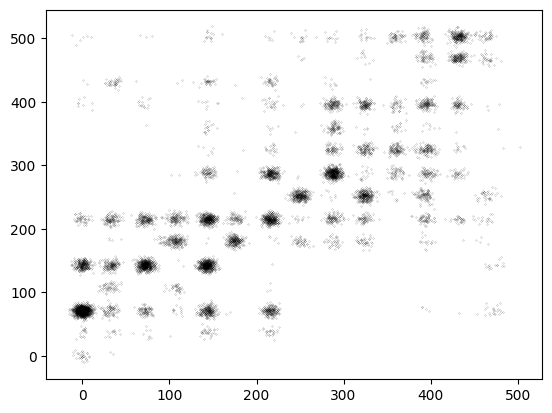

(PearsonRResult(statistic=0.7581523545601477, pvalue=0.0),
 SignificanceResult(statistic=0.7899166009757168, pvalue=0.0))

In [36]:
df0 = pd.read_csv(fn_eval_output)
fn = os.path.join(dir_model, "EVAL_PSYCHOPHYSICSv00_mp_spectral_cues.json")
df1 = pd.read_json(fn).sort_values(by="index").reset_index(drop=True)

# df0 = df0.sort_values(
#     by=[
#         "index",
#         "snr",
#         "index_room",
#         "index_brir",
#         "label_speaker_int",
#         "label_word_int",
#     ]
# )
# df1 = df1.sort_values(
#     by=[
#         "index",
#         "snr",
#         "index_room",
#         "index_brir",
#         "label_speaker_int",
#         "label_word_int",
#     ]
# )

fig, ax = plt.subplots()
x = df1["label_loc_int:labels_pred"].values
y = df0["label_loc_int.pred"].values
ax.plot(x + 5 * np.random.randn(*y.shape), y + 5 * np.random.randn(*y.shape), "k.", ms=0.2)
plt.show()

scipy.stats.pearsonr(x, y), scipy.stats.spearmanr(x, y)


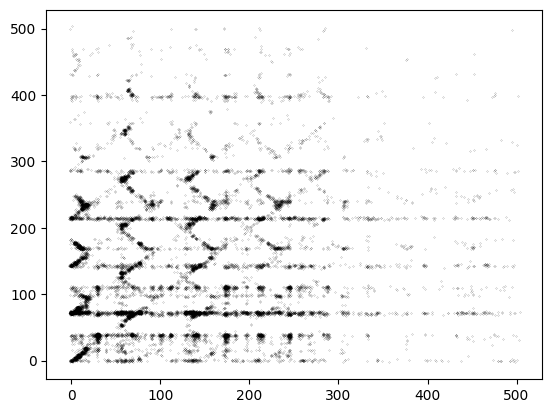

(PearsonRResult(statistic=0.09967354422384994, pvalue=1.0185401591659618e-42),
 SignificanceResult(statistic=0.09849514320543601, pvalue=9.457196290683313e-42))

In [32]:
df0 = pd.read_csv(fn_eval_output)
fn = os.path.join(dir_model, "EVAL_PSYCHOPHYSICSv00_speech_in_noise_in_reverb_v04.json")
df1 = pd.read_json(fn).sort_values(by="index").reset_index(drop=True)

df0 = df0.sort_values(
    by=[
        "index",
        "snr",
        "index_room",
        "index_brir",
        "label_speaker_int",
        "label_word_int",
    ]
)
df1 = df1.sort_values(
    by=[
        "index",
        "snr",
        "index_room",
        "index_brir",
        "label_speaker_int",
        "label_word_int",
    ]
)

fig, ax = plt.subplots()
x = df1["label_loc_int:labels_pred"].values
y = df0["label_loc_int.pred"].values
ax.plot(x + 1 * np.random.randn(*y.shape), y + 1 * np.random.randn(*y.shape), "k.", ms=0.2)
plt.show()

scipy.stats.pearsonr(x, y), scipy.stats.spearmanr(x, y)


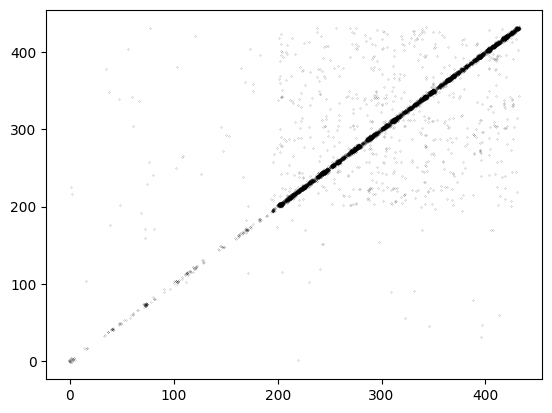

SignificanceResult(statistic=0.9386013264001644, pvalue=0.0)

In [11]:
df0 = pd.read_csv(fn_eval_output)
fn = os.path.join(dir_model, "EVAL_pitch_altered_v00.json")
df1 = pd.read_json(fn).sort_values(by="index").reset_index(drop=True)

fig, ax = plt.subplots()
x = df1["label_speaker_int:labels_pred"].values
y = df0["label_speaker_int.pred"].values
ax.plot(x + 1 * np.random.randn(*y.shape), y + 1 * np.random.randn(*y.shape), "k.", ms=0.2)
plt.show()

scipy.stats.pearsonr(x, y), scipy.stats.spearmanr(x, y)
